<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| [Emmanuel Rachelson](https://personnel.isae-supaero.fr/emmanuel-rachelson?lang=en) | <a href="https://supaerodatascience.github.io/machine-learning/">https://supaerodatascience.github.io/machine-learning/</a>

<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Unsupervised Learning</div>

The objective of this notebook is to discover the beginning of the **Data Analysis Workflow** :
1. Collect
2. Analyze
3. Deploy
4. Decide


At the same time we will discover **three Unsupervized Learning** tasks are illustrated here:
1. [Dimensionality reduction](#dim)
2. [Clustering](#clust)
3. [Density estimation](#density)

 The goal is not to explain the algorithms in depth, but rather to understand the tasks they solve and see them in action. This is the occasion to familiarize ourselves with the scikit-learn API. 

As we have seen in the introduction to Machine Learning, Unsupervised Learning is concerned with learning *structure* from raw inputs, without the help of a *supervisor* who would help map examples to labels. There are three main categories of things one can learn without supervision:
- A statistically relevant description of the data. That's the goal of *[Dimensionality reduction](#dim)*. It is intensively used for *data visualization* and exploration. It is strongly linked to previous classes in Statistics and the Introduction to Statistical Learning. It will be covered again in future classes using non-linear methods. 
- Categories of similar data. This supposes some implicit metric allowing to define distances between data samples. This is the goal of *[Clustering](#clust)*, which has already been covered in the Statistics class.
- Generating distributions underlying the observed data. That's the goal of *[Density estimation](#density)*, which will be proposed as a "going further" exercice in the SVM notebook (next class).

# <a id="dim"></a> 1. Dimensionality reduction


<img id="fig1" src="https://imgs.xkcd.com/comics/real_estate.png">

A Real estate company comes to you : they have been **collecting data** for years, and know they think they can make some business with them.

You start the **analysis** by loading and plotting them.

**Disclamer** :
The Boston housing prices dataset has an ethical problem. As an introduction to Usupervised learning, this course decides to keep using this dataset to educate about biais and ethical issues in data science.


If you prefer to work on an other dataset, you can load an alternative dataset with :

from sklearn.datasets import fetch_california_housing
boston = fetch_california_housing()



In [1]:
import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
Y = raw_df.values[1::2, 2]

**Questions** :
- What does the phrase "Median Value (attribute 14) is usually the target" means ?
- Using one of the basic plot from the **bokeh** library [https://docs.bokeh.org/en/latest/docs/user_guide/plotting.html#userguide-plotting](here), create one plot showing two interesting features.  
- What other feature would you have proposed to collect ?

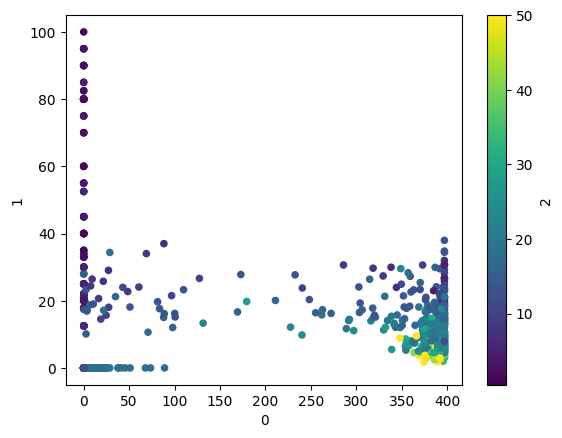

In [4]:
# Your plot here
import matplotlib.pyplot as plt

raw_df.plot.scatter(x=0, y=1, c=2, colormap='viridis')
plt.show()

There are 13 variables in this data set. But only 506 data points. That's very little for a hypercube in 13-dimensional space. Probably the variables describing house prices by neighborhoods are correlated and the data does not really live in $\mathbb{R}^{13}$, but rather on a manifold. Maybe the data could be more easily described with a few well-chosen variables. If only we had heard of Principal Component Analysis in previous classes!

**Questions** : 
- In the following cells, what is the parameter "explained_variance_ratio_" ?
- What is the difference between feature selection and feature engineering ?
- After plotting the data using PCA, what kind of applications could you propose to the Real Estate company ?

In [5]:
from sklearn.decomposition import PCA

print(X.shape)

boston_pca = PCA()
boston_pca.fit(X)

(506, 13)


PCA()

In [6]:
boston_pca.explained_variance_ratio_

array([8.05823175e-01, 1.63051968e-01, 2.13486092e-02, 6.95699061e-03,
       1.29995193e-03, 7.27220158e-04, 4.19044539e-04, 2.48538539e-04,
       8.53912023e-05, 3.08071548e-05, 6.65623182e-06, 1.56778461e-06,
       7.96814208e-08])

So, apparently, 80% of the data's variance is already explained by the first principal component. And another 16% can be explained by the second principal component. Let's plot the histogram of explained variance ratio.

<BarContainer object of 13 artists>

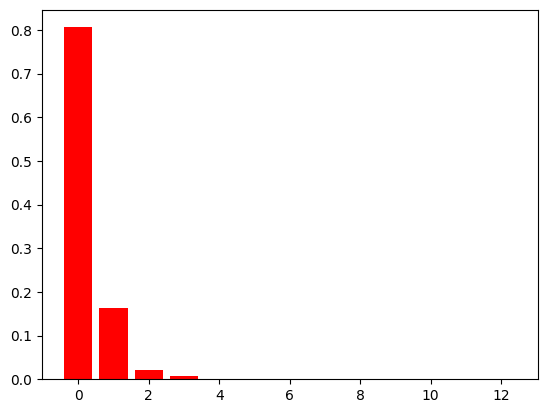

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.bar(range(X.shape[1]), boston_pca.explained_variance_ratio_, color="r", align="center")

Let's confirm the amount of variance captured by these first two components.

In [8]:
import numpy as np

np.sum(boston_pca.explained_variance_ratio_[:2])

0.9688751429772734

Ok, let's retrain the same PCA so that it provides a projection operator on the two first components.

In [9]:
boston_pca = PCA(n_components=2)
boston_pca.fit(X)
X_proj = boston_pca.transform(X)

In [10]:
X_proj.shape

(506, 2)

Let's take a look at these two principal components.

In [11]:
boston_pca.components_

array([[ 2.92973218e-02, -4.35898000e-02,  2.83309382e-02,
        -5.55846350e-05,  4.49721818e-04, -1.16815860e-03,
         8.36335746e-02, -6.56163360e-03,  4.50053753e-02,
         9.49741169e-01,  5.60011721e-03, -2.91218514e-01,
         2.29433756e-02],
       [ 6.66847277e-03,  1.17564821e-03, -4.94975624e-03,
        -1.02678850e-04,  1.82069867e-06,  3.65750108e-04,
        -5.72246652e-03,  3.53685109e-04, -8.61865948e-03,
        -2.92406308e-01, -2.52898538e-03, -9.56180551e-01,
         5.76719865e-03]])

Let's now plot the data projected onto these two principal components.

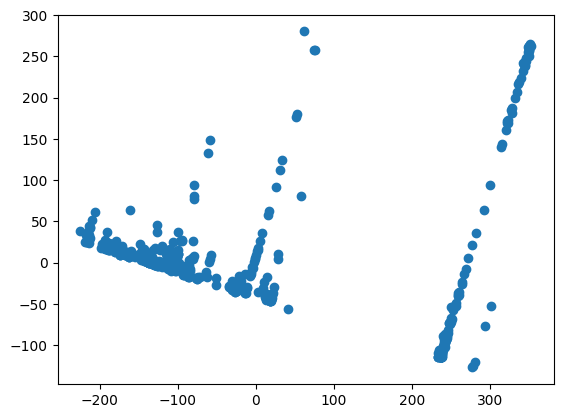

In [12]:
plt.scatter(X_proj[:,0],X_proj[:,1]);

[Going further with PCA in scikit-learn](https://scikit-learn.org/stable/modules/decomposition.html#principal-component-analysis-pca).

# <a id="clust"></a> 2. Clustering

Now that we have filtered out irrelevant dimensions in our data and started exploring it, it seems two types of houses appear. Let's try to group these houses by similarity in the projection space of the two first principal components. This is a task of clustering.

In [13]:
from sklearn.cluster import KMeans
boston_kmeans = KMeans(n_clusters=2)
boston_kmeans.fit(X_proj)

KMeans(n_clusters=2)

Let's now plot the data by cluster.

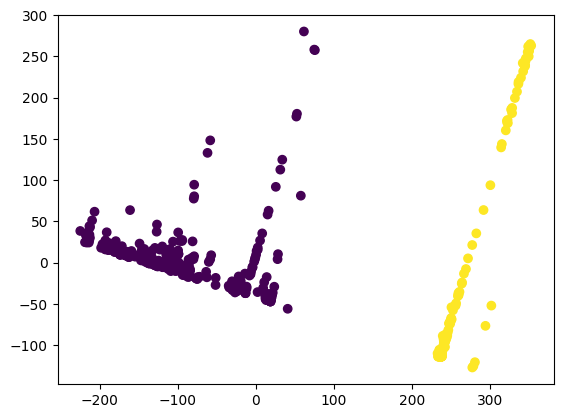

In [14]:
y_pred = boston_kmeans.predict(X_proj)
plt.scatter(X_proj[:,0], X_proj[:,1], c=y_pred);

Maybe we could have done this clustering directly in the original $\mathbb{R}^{13}$ description space. Let's run the k-means algorithm again, predict what samples correspond to what class and then display them in the plane spanned by two first principal components.

In [ ]:
boston_kmeans2 = KMeans(n_clusters=2)
boston_kmeans2.fit(X)
y_pred = boston_kmeans2.predict(X)
plt.scatter(X_proj[:,0], X_proj[:,1], c=y_pred);

**Questions** : 
- What is the difference between fit and predict ?
- How many clusters is too many ?
- Using sklearn [examples](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html), what would be an interesting alternative to kmeans (and test it) ?
- How do you explain to the Real Estate company what are the characteristic of each cluster, with a bokeh plot ?

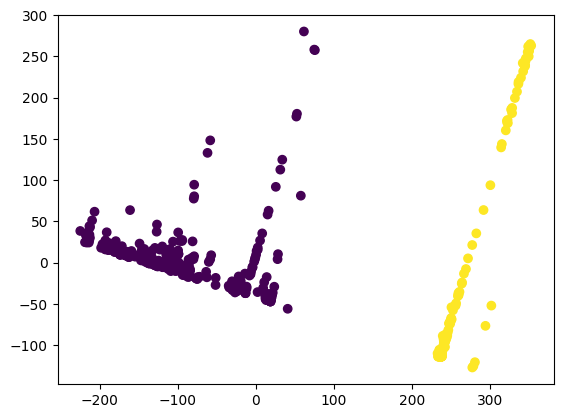

In [15]:
# your plot here, to explain your results to the Real Estate company
plt.scatter(X_proj[:,0], X_proj[:,1], c=y_pred);

See this [example](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html) for a great comparison of clustering methods.

[Going further with k-means in scikit-learn](https://scikit-learn.org/stable/modules/clustering.html#k-means).

# <a id="density"></a> 3. Density estimation

Finally, we would like to estimate the likelihood of seeing new houses similar to those of the first cluster. More specifically, we would like to visualize the probability density underlying this cluster. This is, yet again, another problem of Unsupervised Learning, called Density Estimation.

This one has not been seen in previous classes and, for now, we will just admit that "One Class SVMs" are a magic class of algorithms that do precisely that: estimate probability densities from data. There are, of course, other density estimation algorithms. Scikit-learn provides [a few of these methods](https://scikit-learn.org/stable/modules/density.html), that are more generally related to the idea of estimating a probability distribution's cumulative distribution function (for example via a histogram).

So let's fit a One Class SVM model to match our first cluster's data distribution in the first two principal components space.

In [ ]:
X1 = X_proj[y_pred==0,:]
plt.scatter(X1[:,0], X1[:,1]);

In [ ]:
from sklearn import svm

boston_ocsvm = svm.OneClassSVM(gamma = 1e-3)
boston_ocsvm.fit(X1)

Let's plot the level set of this density function.

In [ ]:
xmin = np.min(X1[:,0])
xmax = np.max(X1[:,0])
ymin = np.min(X1[:,1])
ymax = np.max(X1[:,1])

xx, yy = np.meshgrid(np.linspace(xmin, xmax, 500), np.linspace(ymin, ymax, 500))

Z = boston_ocsvm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.PuBu);
#plt.scatter(X1[:,0], X1[:,1]);

We could also be curious and, since One Class SVMs are a rather versatile tool, we could try to fit the full data set (and not just the first cluster) and then display it on the plane spanned by the two first principal components.

In [ ]:
boston_ocsvm = svm.OneClassSVM(gamma = 1e-3)

boston_ocsvm.fit(X_proj)

xmin = np.min(X_proj[:,0])
xmax = np.max(X_proj[:,0])
ymin = np.min(X_proj[:,1])
ymax = np.max(X_proj[:,1])

xx, yy = np.meshgrid(np.linspace(xmin, xmax, 500), np.linspace(ymin, ymax, 500))

Z = boston_ocsvm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.PuBu);
plt.scatter(X_proj[:,0], X_proj[:,1]);


**Questions**:
- Using the previous cells, what threshold would you choose to define outliers ?
- Is there on best order to apply the preprocessing steps ? (PCA, clustering, outliers detection ) ?
- Produce two files (on a relevant part of the data) : one called "training_dataset.csv" and the other one called "testing_dataset.csv"

In [ ]:
# Your export code here